In [1]:
import pandas as pd
import numpy as np
import tarfile
import io
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

As the the total data size is very huge, one data file was summarized here as an example of exploratory data analysis. The findings were similar among different files.

In [2]:
file_list = []
for logN in range(1):
    file_list.append('../data/raw/training_set/log_'+str(logN)+'_20180917_000000000000.csv')

file_list

['../data/raw/training_set/log_0_20180917_000000000000.csv']

# Inspecting the basic properties of the listening session data log_df

Here is the official file explaining the schema of the dataset: https://github.com/curlsloth/Capstone_Spotify-Sequential-Skip-Prediction/blob/main/references/Dataset%20Description.pdf

In [3]:
log_df = pd.read_csv(file_list[0])
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122466 entries, 0 to 3122465
Data columns (total 21 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   session_id                       object
 1   session_position                 int64 
 2   session_length                   int64 
 3   track_id_clean                   object
 4   skip_1                           bool  
 5   skip_2                           bool  
 6   skip_3                           bool  
 7   not_skipped                      bool  
 8   context_switch                   int64 
 9   no_pause_before_play             int64 
 10  short_pause_before_play          int64 
 11  long_pause_before_play           int64 
 12  hist_user_behavior_n_seekfwd     int64 
 13  hist_user_behavior_n_seekback    int64 
 14  hist_user_behavior_is_shuffle    bool  
 15  hour_of_day                      int64 
 16  date                             object
 17  premium                    

In [4]:
log_df.head().T

,0,1,2,3,4
session_id,64_00015322-1e17-40d9-865d-4887eea2b659,64_00015322-1e17-40d9-865d-4887eea2b659,64_00015322-1e17-40d9-865d-4887eea2b659,64_00015322-1e17-40d9-865d-4887eea2b659,64_00015322-1e17-40d9-865d-4887eea2b659
session_position,1,2,3,4,5
session_length,19,19,19,19,19
track_id_clean,t_e587194e-c1a1-4177-b089-e4c37dd7a24d,t_039553af-ae1b-45ce-9efa-e27ad7db88a6,t_fb5ede48-6706-429b-abf8-243559f3f94b,t_e6cf4873-d8bb-4894-91cd-1ef4f18f5908,t_b74ec0be-4204-43b1-ab03-a42b2744c3ad
skip_1,False,False,False,False,True
skip_2,False,False,False,False,True
skip_3,False,True,False,False,True
not_skipped,True,False,True,True,False
context_switch,0,0,0,0,0
no_pause_before_play,0,0,1,1,0


# The goal is to predict the variable 'skip_2' as True or False
'skip_2' variable represents a track was skipped or not after being played briefly

First, I checked the general skipping rate of the data, in case I need to deal with unbalanced dataset in the machine learning model.

In [5]:
print('skipping rate:',log_df['skip_2'].mean())

skipping rate: 0.5040990038002016


/Users/andrewchang/opt/anaconda3/envs/Springboard_new/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


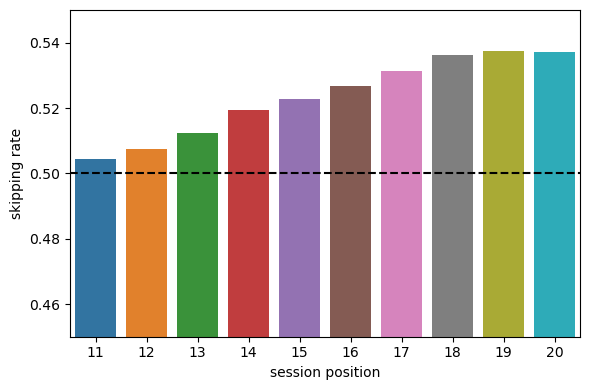

In [6]:
skip_by_position = pd.DataFrame(log_df.groupby(['session_position'])['skip_2'].mean())
fig, ax = plt.subplots(figsize=(6,4)) 

graph = sns.barplot(skip_by_position[10:].T, ax=ax)
ax.set_ylabel('skipping rate')
ax.set_xlabel('session position')
graph.axhline(0.5, linestyle = '--', c = 'k')
plt.ylim(0.45,0.55)
plt.tight_layout()
plt.show()


In general, the skip_2 True and False labels were very balanced. Even the skipping rate was a bit higher for the tracks in a later position in a session, the difference is less than 4%, which is ignorable.

### The distribution of the session lengths in the dataset was check, as the sequential listening data was organized by session

/var/folders/g1/pt2wv7fn1txcdflc2vs67qsr0000gn/T/ipykernel_33653/86954551.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  log_df_s_mean = log_df.groupby(['session_id']).mean()


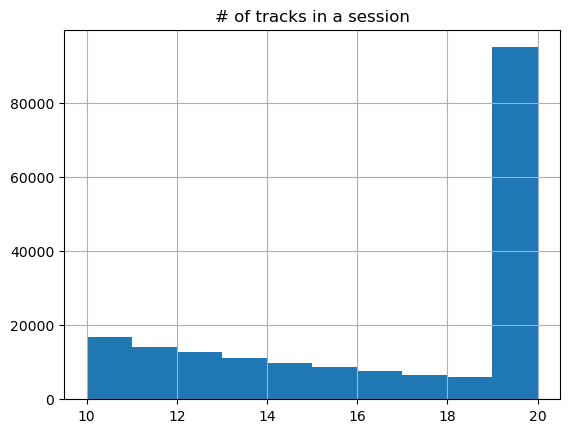

In [7]:
log_df_s_mean = log_df.groupby(['session_id']).mean()
log_df_s_mean['session_length'].hist()
plt.title('# of tracks in a session')
plt.show()

In [8]:
print('% of sessions having 20 tracks:',(log_df_s_mean['session_length']==20).mean())

% of sessions having 20 tracks: 0.4764248883507777


# Inspecting the basic properties of the track data
The features of each music track are summarized in separate data files. Specifically, see this for further explanations of the acoustic analyses: https://github.com/curlsloth/Capstone_Spotify-Sequential-Skip-Prediction/blob/main/references/acousticness.pdf

In [10]:
tar = tarfile.open('../data/raw/20181120_track_features.tar.gz', 'r:gz')
csv_files = tar.getnames()

tf_df_list = []

for csv_file in [csv_files[2], csv_files[4]]:
    csv_contents = tar.extractfile(csv_file).read()
    tf_df_list.append(pd.read_csv(io.BytesIO(csv_contents), encoding='utf8'))

tf_df = pd.concat(tf_df_list, ignore_index=True)

# the major/minor mode needs to be coded as 'is_major' (boolean)
tf_df['is_major'] = tf_df['mode']=='major'
tf_df.drop(columns=['mode'], inplace=True)

In [11]:
tf_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
track_id,t_2e8f4b71-8a0b-4b9c-b7d8-fb5208e87f9f,t_dae2ec0e-ec7b-4b3e-b60c-4a884d0eccb0,t_cf0164dd-1531-4399-bfa6-dec19cd1fedc,t_0f90acc7-d5c5-4e53-901d-55610fbd090c,t_36b9ad02-095a-443d-a697-6c7285d9410a,t_cbf7084a-0ab7-40b2-8e47-a010580e8d15,t_2ee16606-ba70-419f-a437-7c6ee2b8ec26,t_3e80fb67-dc0b-4a97-aff8-88d82f452f9d,t_f9b9a072-8dae-4816-bfd6-d91fc75a5744,t_d076e5fa-174c-4614-a1b8-371bd0ea3343
duration,326.013336,147.813324,110.400002,237.653336,174.600006,164.826675,262.706665,244.666672,180.133331,141.226669
release_year,1971,1963,1974,1988,1987,1956,1963,1988,1989,1966
us_popularity_estimate,99.582885,97.272035,99.620384,96.79683,97.905891,92.592429,99.183088,97.830526,97.720734,90.320035
acousticness,0.716209,0.83946,0.054673,0.042606,0.249982,0.734342,0.79803,0.513671,0.002047,0.988567
beat_strength,0.366495,0.362212,0.495002,0.389634,0.51364,0.165064,0.414411,0.658134,0.425469,0.388165
bounciness,0.332605,0.389829,0.589378,0.359044,0.485435,0.140488,0.440939,0.653404,0.486543,0.380072
danceability,0.439835,0.50758,0.552311,0.585673,0.635095,0.199769,0.383561,0.734945,0.65454,0.49712
dyn_range_mean,5.805774,6.845427,9.361949,6.068578,7.198735,4.153819,7.293006,9.109443,7.990334,6.464887
energy,0.238847,0.420476,0.842938,0.665398,0.408715,0.379919,0.422262,0.701644,0.625231,0.200862


### The distribution of the data of each column appeared reasonable. 

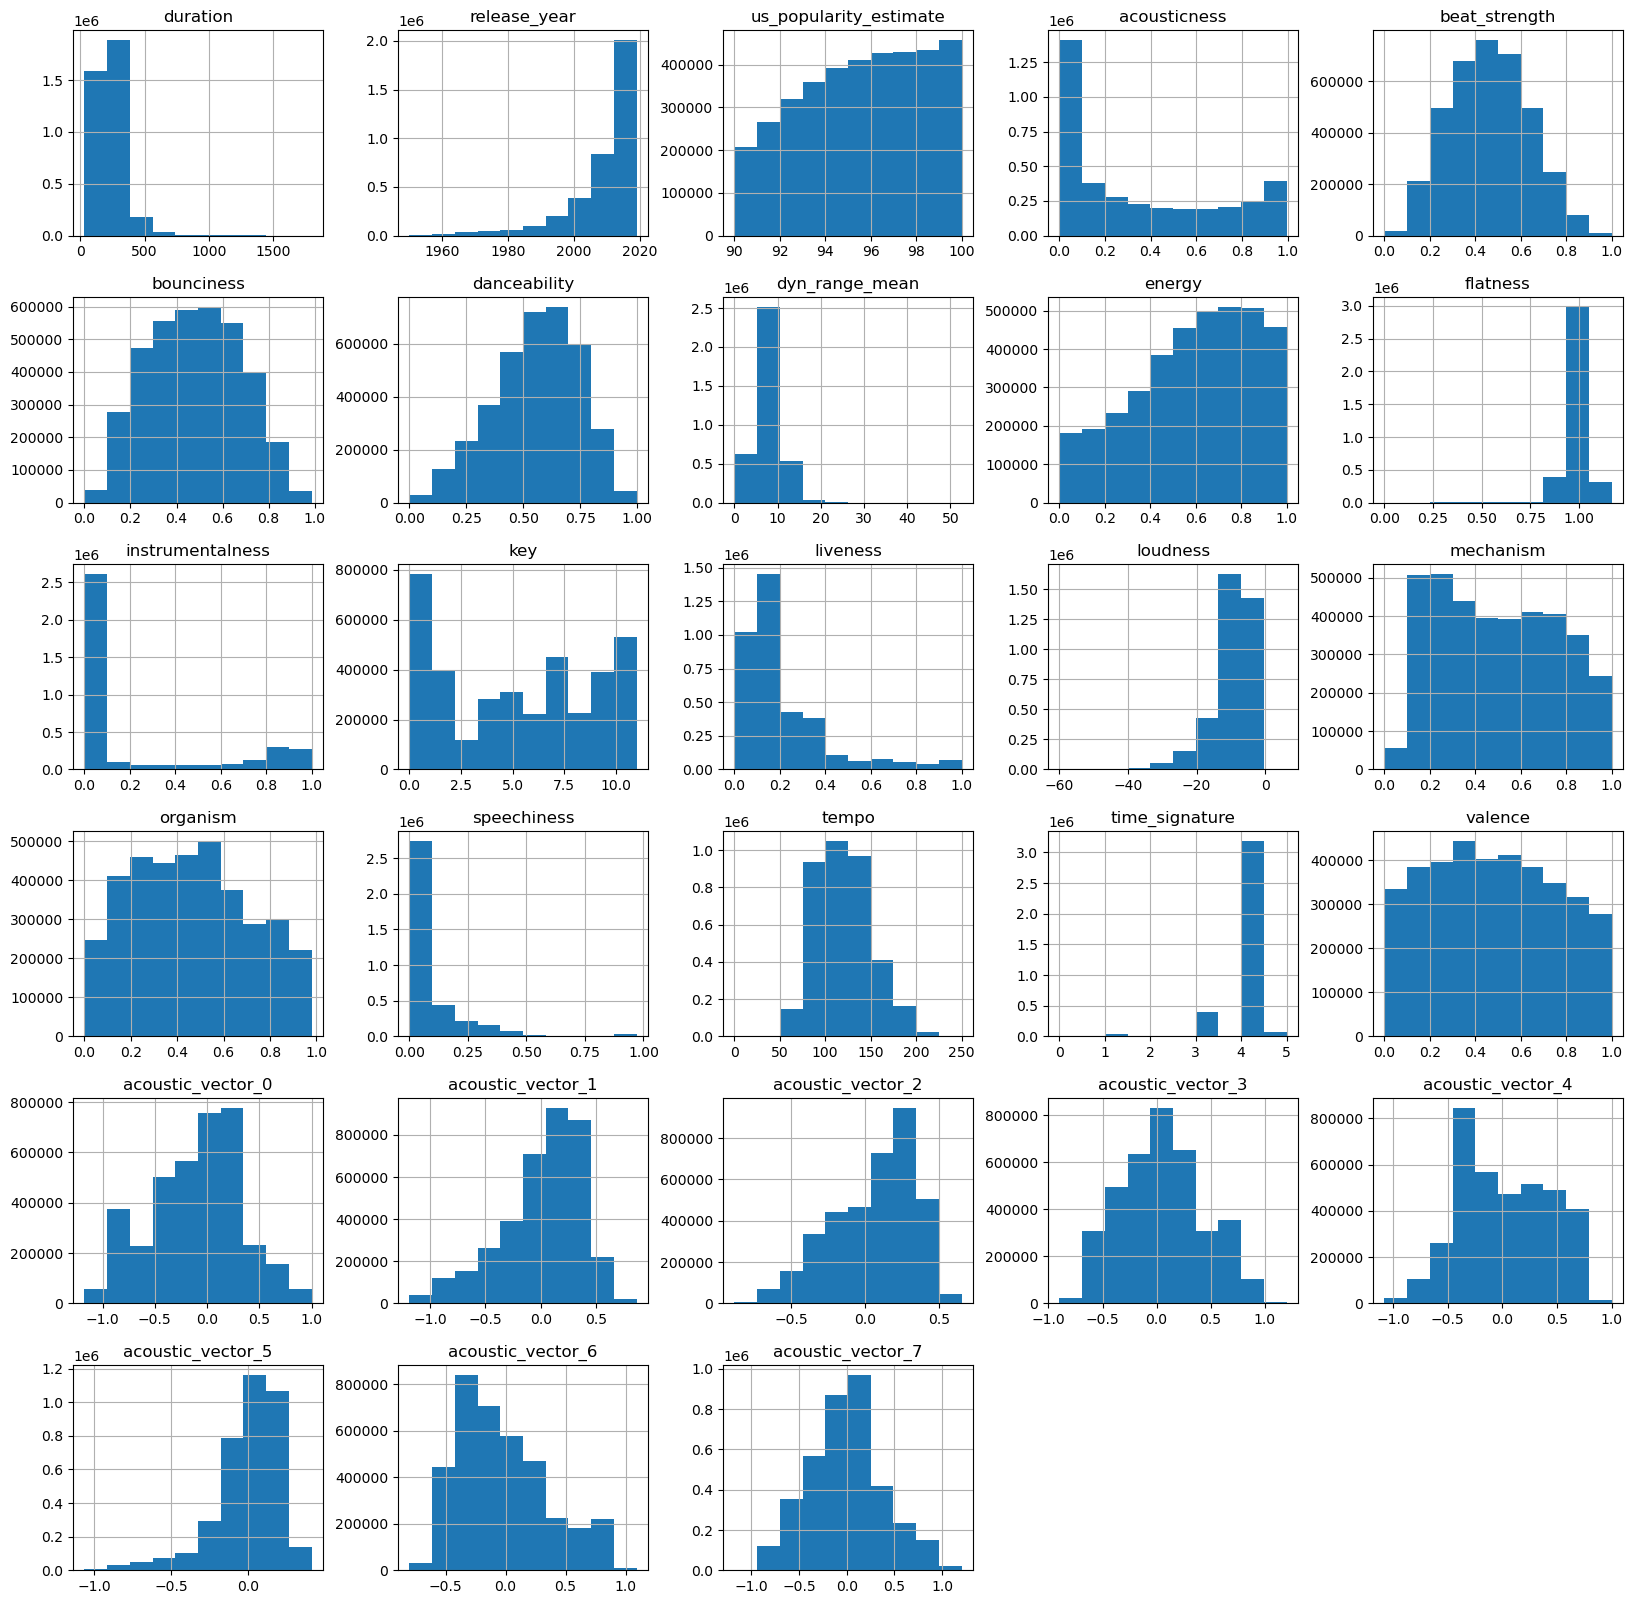

In [12]:
tf_hist = tf_df.hist(figsize = (20,20))

Note that the 'key' variable is actually a categorical variable representing 12 possible keys of Western music. The 'time_signature' and 'mode' are categorical variables too.

### Simple pairwise Spearman correlations were performed to quickly examined the dependency among the track variables.

Non-linear Spearman correlation was used instead of linear Pearson correlation as some variables have weird distribution and the subsequent machine learning model might not be linear. Therefore, the non-linear correlation here could be more informative.

/var/folders/g1/pt2wv7fn1txcdflc2vs67qsr0000gn/T/ipykernel_33653/1037090394.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap( tf_df.corr(method='spearman'), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f", ax = ax)


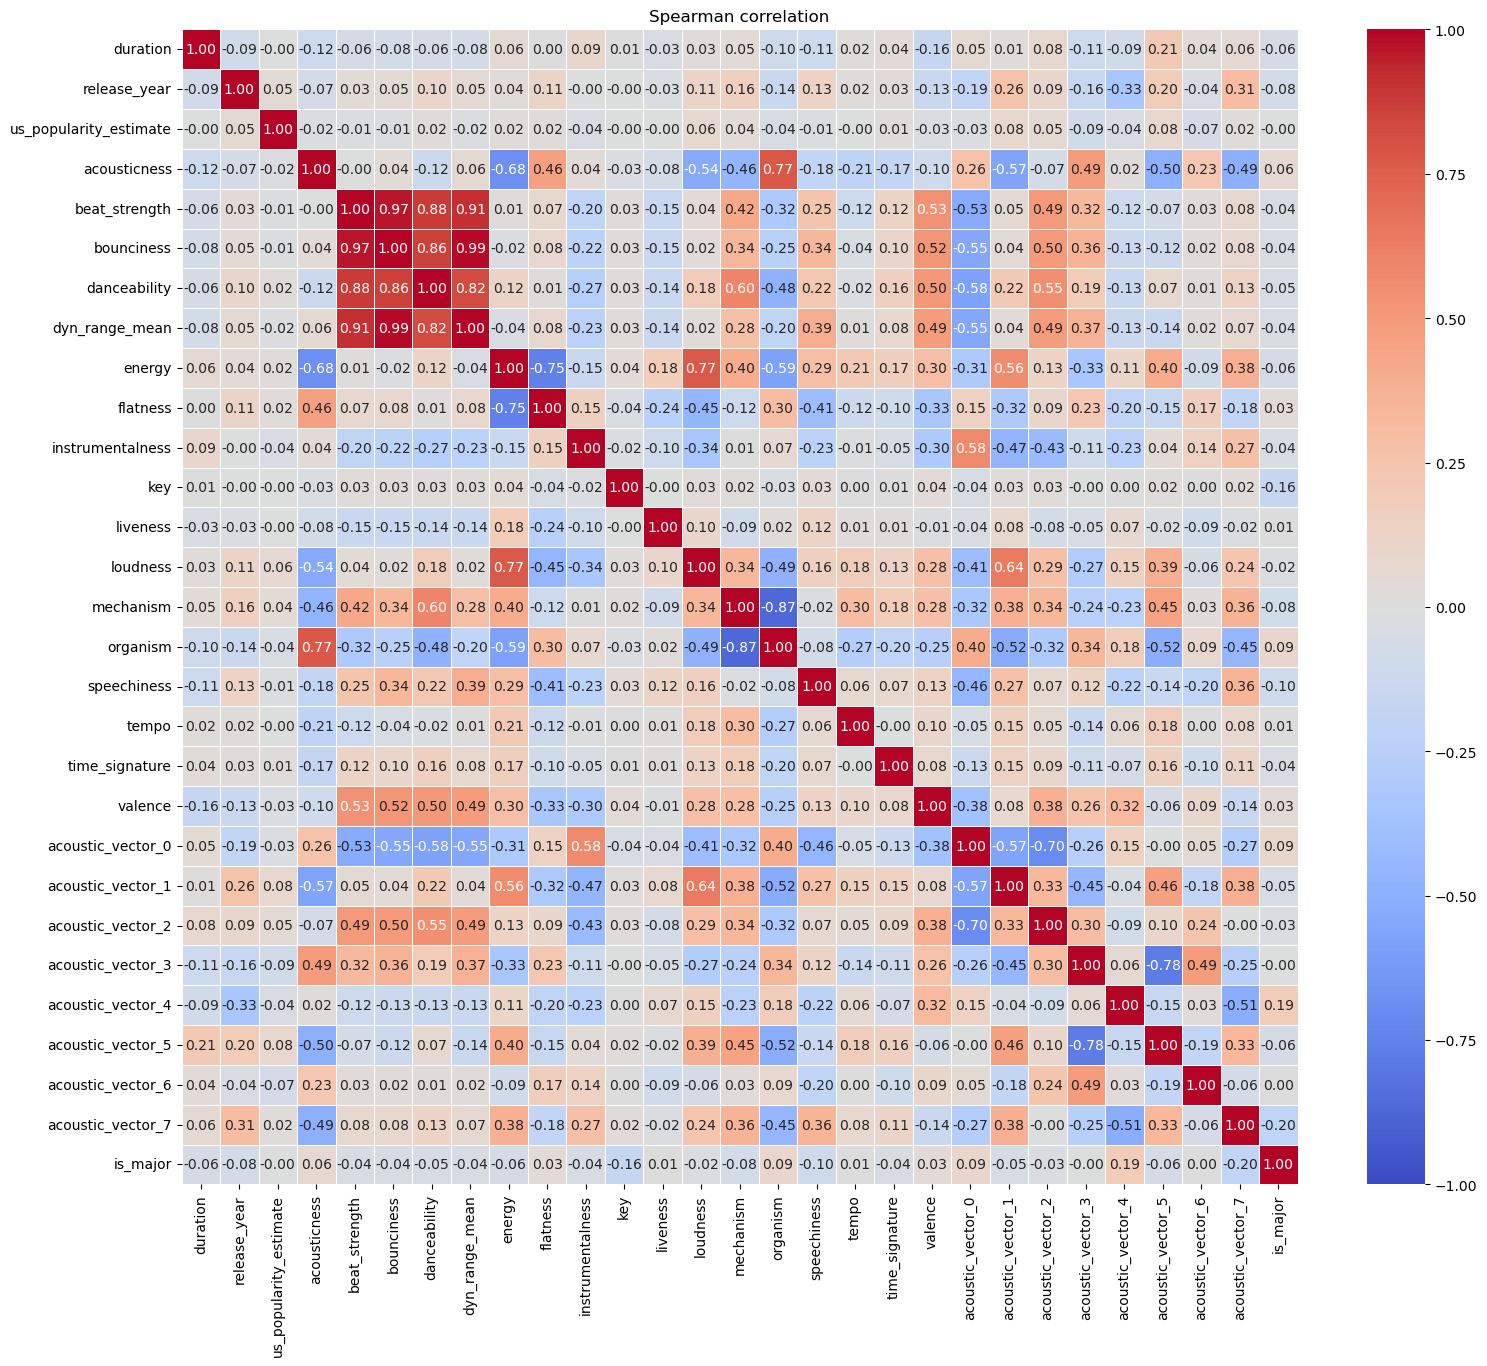

In [13]:
fig, ax = plt.subplots(figsize=(18,15)) 
sns.heatmap( tf_df.corr(method='spearman'), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f", ax = ax)
plt.title('Spearman correlation')
plt.show()

It is good that most of the variables are quite independent from each other, except that the 'beat_strength', 'bounciness', 'dancibility', and 'dyn_range_mean' variables are highly correlated. It is not surprising as those concepts are highly associated as well. Therefore, if there is a colinearity concern in the subsequent model fitting, these 4 variables can be reduced to 1.

# Any difference between skipped vs non-skipped tracks?
Before working on any complicated machine learning model, I am checking whether there's any differences between the tracks being skipped or not using paired t-tests.
First, some categorical variabels was dummy-coded.
Second, the data of listening session data and track features were joined

In [14]:
log_df_dummy = pd.get_dummies(log_df, columns=['hist_user_behavior_reason_start','hist_user_behavior_reason_end','context_type'])
tf_df_dummy = pd.get_dummies(tf_df, columns=['key','time_signature'])

df_merge = pd.merge(log_df_dummy, tf_df_dummy, how='left', left_on='track_id_clean', right_on = 'track_id')
df_merge.head()


,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,key_7,key_8,key_9,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,64_00015322-1e17-40d9-865d-4887eea2b659,1,19,t_e587194e-c1a1-4177-b089-e4c37dd7a24d,False,False,False,True,0,0,...,1,0,0,0,0,0,0,0,1,0
1,64_00015322-1e17-40d9-865d-4887eea2b659,2,19,t_039553af-ae1b-45ce-9efa-e27ad7db88a6,False,False,True,False,0,0,...,0,0,0,0,0,0,0,0,1,0
2,64_00015322-1e17-40d9-865d-4887eea2b659,3,19,t_fb5ede48-6706-429b-abf8-243559f3f94b,False,False,False,True,0,1,...,1,0,0,0,0,0,0,0,1,0
3,64_00015322-1e17-40d9-865d-4887eea2b659,4,19,t_e6cf4873-d8bb-4894-91cd-1ef4f18f5908,False,False,False,True,0,1,...,0,0,0,0,0,0,0,0,1,0
4,64_00015322-1e17-40d9-865d-4887eea2b659,5,19,t_b74ec0be-4204-43b1-ab03-a42b2744c3ad,True,True,True,False,0,0,...,0,0,0,0,1,0,0,0,1,0


### Dropping the columns which had the same value for each session or highly associated with 'skip_2'
Those factors will make the paired t-test meaningless.

In [15]:
dropping_columns = ['session_length','context_switch','hour_of_day','date','premium','skip_1','skip_2','skip_3','not_skipped']
df_merge_skipT = df_merge[df_merge['skip_2']==True].drop(columns = dropping_columns).groupby('session_id').mean()
df_merge_skipF = df_merge[df_merge['skip_2']==False].drop(columns = dropping_columns).groupby('session_id').mean()
df_merge_skipT.sort_index(inplace = True)
df_merge_skipF.sort_index(inplace = True)

/var/folders/g1/pt2wv7fn1txcdflc2vs67qsr0000gn/T/ipykernel_33653/3617323311.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merge_skipT = df_merge[df_merge['skip_2']==True].drop(columns = dropping_columns).groupby('session_id').mean()
/var/folders/g1/pt2wv7fn1txcdflc2vs67qsr0000gn/T/ipykernel_33653/3617323311.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merge_skipF = df_merge[df_merge['skip_2']==False].drop(columns = dropping_columns).groupby('session_id').mean()


In [16]:
df_merge_skipT.head().T

session_id,64_00015322-1e17-40d9-865d-4887eea2b659,64_00015b21-513c-40e5-989d-2763976d480c,64_0001849a-35e6-404c-bbb4-c6c87a205fd7,64_00029bf8-5e5a-4737-97ec-49331990b8b2,64_0003a7b3-b6f2-4382-8710-3bee8b5642ae
session_position,11.500000,7.166667,14.000000,7.0,9.000
no_pause_before_play,0.928571,0.500000,0.714286,0.6,0.875
short_pause_before_play,0.071429,0.000000,0.000000,0.2,0.125
long_pause_before_play,0.071429,0.333333,0.285714,0.2,0.125
hist_user_behavior_n_seekfwd,0.000000,0.000000,0.142857,0.0,0.000
...,...,...,...,...,...
time_signature_0,0.000000,0.000000,0.000000,0.0,0.000
time_signature_1,0.000000,0.000000,0.000000,0.0,0.000
time_signature_3,0.071429,0.166667,0.142857,0.0,0.125
time_signature_4,0.928571,0.833333,0.857143,1.0,0.875


In [17]:
df_merge_skipF.head().T

session_id,64_00015322-1e17-40d9-865d-4887eea2b659,64_00015b21-513c-40e5-989d-2763976d480c,64_0001849a-35e6-404c-bbb4-c6c87a205fd7,64_00029bf8-5e5a-4737-97ec-49331990b8b2,64_0003a7b3-b6f2-4382-8710-3bee8b5642ae
session_position,5.8,10.666667,8.615385,7.777778,8.000
no_pause_before_play,0.6,0.583333,0.461538,0.888889,0.625
short_pause_before_play,0.2,0.083333,0.307692,0.111111,0.125
long_pause_before_play,0.2,0.416667,0.461538,0.111111,0.250
hist_user_behavior_n_seekfwd,0.0,0.000000,0.000000,0.111111,0.000
...,...,...,...,...,...
time_signature_0,0.0,0.000000,0.000000,0.000000,0.000
time_signature_1,0.0,0.000000,0.153846,0.000000,0.000
time_signature_3,0.0,0.250000,0.153846,0.000000,0.000
time_signature_4,1.0,0.750000,0.692308,1.000000,1.000


In [18]:
if len(df_merge_skipT) == len(df_merge_skipF): # sanity check!
    result = stats.ttest_rel(df_merge_skipT,df_merge_skipF)

### Sorted the top 30 columns which had the biggest differences (unsigned t-values) between skipped and non-skipped tracks

In [19]:
sorted_tvalues = np.abs(pd.DataFrame(index = df_merge_skipT.columns, data = list(result.statistic))).sort_values(by=0, ascending=False)
sel_range = 30
sorted_tvalues = sorted_tvalues.iloc[:sel_range]

/Users/andrewchang/opt/anaconda3/envs/Springboard_new/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


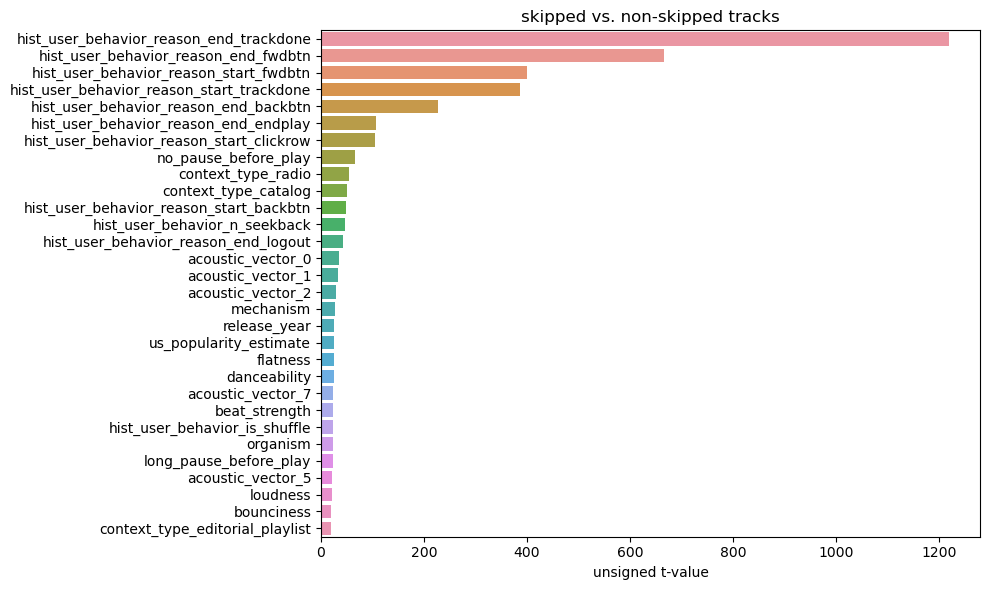

In [20]:
fig, ax = plt.subplots(figsize=(10,6)) 

graph = sns.barplot(data = sorted_tvalues.T, ax=ax, orient = 'h')
ax.set_xlabel('unsigned t-value')
plt.title('skipped vs. non-skipped tracks')
plt.tight_layout()
plt.show()

It appeared that the **listening behaviors (reasons to start and end) are closely associated with the skipping behavior.** Would it be a circular reasoning that a track was skipped because the user had a reason to skip it? Possible! But it could be a good predictor too, as a user might want to keep skipping tracks as he/she is looking for something specific.

Another interesting observation is that the **track features had relatively low associations with skipping behavior.** It makes sense as skip_2 means the users skip a trac only after listening for a brief period. However, the track features were obtained by analyzing the entire track. Therefore, such information has not been perceived by the users at the moment they skip it.